In [1]:
import axelrod as axl

### LookUp Player

To represent a strategy in the Axelrod package and be able to run matches and tournaments with it, we need to create a **strategy class**. Each strategy in the package is implemented as a class. You can find the source code for your favourite strategy [here](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html).

In this exercise, we will create a `LookUpPlayer` class. This strategy considers:

* The player's **last two actions**
* The opponent's **last two actions**
* The opponent's **first two moves**

Based on this context, it makes a **deterministic decision** on whether to cooperate or defect.

The input to the strategy class is a **dictionary**, a lookup table that maps each possible history combination to an action!


In [2]:
C, D = axl.Action.C, axl.Action.D

class LookerUp(axl.Player):

    name =  'LookerUp'

    def __init__(self, lookup_table):
        super().__init__()
        self.lookup_table = lookup_table
    
    def strategy(self, opponent):
        # If there isn't enough history to lookup an action, cooperate.
        if len(self.history) < 2:
            return C

        # Get my own last two actions
        my_history = ''.join([action.name for action in self.history[-2:]])

        # Do the same for the opponent.
        opponent_history = ''.join([action.name for action in opponent.history[-2:]])

        # Get the opponents first two actions.
        opponent_start = ''.join([action.name for action in opponent.history[:2]])

        # Put these three strings together in a tuple.
        key = (opponent_start, my_history, opponent_history)

        # Look up the action associated with that tuple in the lookup table.
        action = self.lookup_table[key]

        return action

## Example of a Single Instance

Using `random` and `itertools`, we will create a ictionary representing the lookup table that serves as input to our strategy class.

We take all possible pairs of actions,`C` and `D`, which are: `CC`, `CD`, `DC`, and `DD`, and generate all possible combinations of three such pairs (representing the history context).

For each combination, we assign a random action (`C` or `D`) to initialize the lookup table.


In [3]:
import random
import itertools

actions = ['C', 'D']
pairings = [''.join(p) for p in itertools.product(actions, repeat=2)]
contexts = list(itertools.product(pairings, repeat=3))

lookup_table = {}

random.seed(20)
for context in contexts:
    lookup_table[context] = random.choice([C, D])

In [4]:
# Create an instance of our new player

player = LookerUp(lookup_table)

In [5]:
axl_first = [axl.TitForTat(), axl.FirstByTidemanAndChieruzzi(), axl.FirstByNydegger(), axl.FirstByGrofman(), axl.FirstByShubik(),
             axl.FirstBySteinAndRapoport(), axl.Grudger(), axl.FirstByDavis(), axl.FirstByGraaskamp(), axl.FirstByDowning(),
             axl.FirstByFeld(), axl.FirstByJoss(), axl.FirstByTullock(), axl.FirstByAnonymous(), axl.Random()]

In [6]:
tournament = axl.Tournament(players=axl_first + [player], repetitions=5, turns=200)

results = tournament.play(progress_bar=False)

/opt/anaconda3/envs/game-python/lib/python3.9/site-packages/axelrod/plot.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


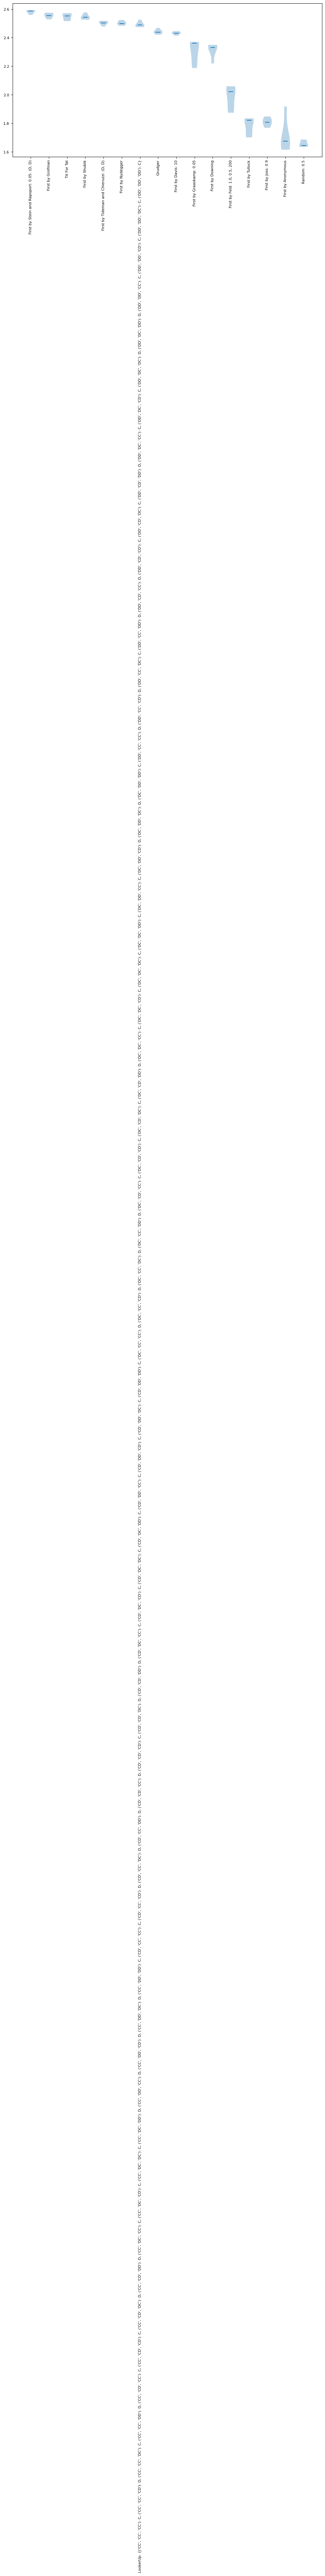

In [7]:
plot = axl.Plot(results)
p = plot.boxplot()

## Randomly Generated Tables

Let us generate 100 random lookup tables and keep track of the mean score achieved by the `LookUp` player.

In [8]:
import numpy as np
from tqdm import tqdm

# to keep track of the mean scores
scores = []

for seed in tqdm(range(100)):
    # Create random input lookup table
    lookup_table = {}

    random.seed(seed)
    for context in contexts:
        lookup_table[context] = random.choice([C, D])

    # Create the player and play the tournament
    player = LookerUp(lookup_table)
    
    tournament = axl.Tournament(players=axl_first + [player], repetitions=5, turns=200)
    results = tournament.play(progress_bar=False)

    players_mean_score = np.mean(results.normalised_scores[-1])
    scores.append(players_mean_score)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]


In [9]:
import matplotlib.pyplot as plt

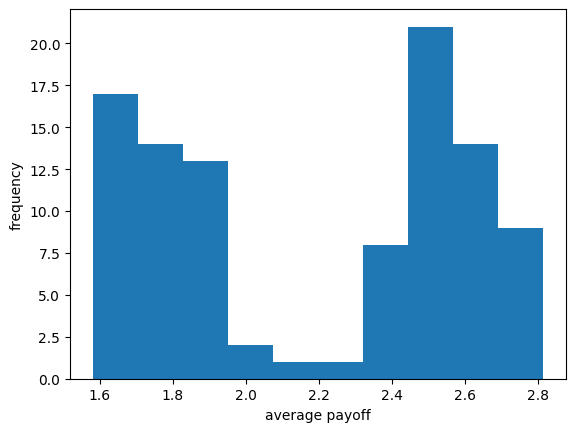

In [10]:
plt.hist(scores);

plt.xlabel("average payoff");
plt.ylabel("frequency");

### Greedy Algorithm

In [11]:
def get_random_table(seed):
    """
    Generate a random lookup table for a LookerUp strategy.

    Each entry in the table maps a 3-tuple of history contexts 
    (opponent's first two moves, player's last two moves, 
    opponent's last two moves) to a randomly selected action ('C' or 'D').

    Parameters:
        seed (int): Random seed for reproducibility.

    Returns:
        dict: A dictionary representing the lookup table, 
              with keys as 3-tuples of string pairs and values as actions ('C' or 'D').
    """
    actions = ['C', 'D']
    pairings = [''.join(p) for p in itertools.product(actions, repeat=2)]
    contexts = list(itertools.product(pairings, repeat=3))

    lookup_table = {}

    random.seed(seed)
    for context in contexts:
        lookup_table[context] = random.choice([C, D])
    return lookup_table


def score_player(table):
    """
    Evaluate the average score of a LookerUp player using a given lookup table.

    The player is added to a tournament against a predefined list of opponents 
    and scored based on its normalized performance over repeated matches.

    Parameters:
        table (dict): A lookup table defining the LookerUp strategy.

    Returns:
        float: The mean normalized score of the LookerUp player 
               across all matches in the tournament.
    """
    player = LookerUp(table)
    
    tournament = axl.Tournament(players=axl_first + [player], repetitions=5, turns=200, seed=0)
    results = tournament.play(progress_bar=False)

    players_mean_score = np.mean(results.normalised_scores[-1])
    return players_mean_score, results.ranking.index(15)

In [12]:
current_table = get_random_table(0)
current_score, current_rank = score_player(current_table)

for i in tqdm(range(500)):
    # flip one key
    new_table = dict(current_table)
    key_to_change = random.choice(list(new_table.keys()))
    new_table[key_to_change] = C if new_table[key_to_change] == D else D

    new_score, new_rank =  score_player(new_table)

    if new_rank < current_rank:
        current_table = new_table
        current_score = new_score
        current_rank = new_rank


    with open("hillclimb.csv", 'a') as output:
        output.write(
            str(current_score) + "," + str(current_rank) 
            + "\n")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [11:02<00:00,  1.33s/it]


In [17]:
import pandas as pd

learning_results = pd.read_csv("hillclimb.csv", header=None)
learning_results.columns = ['avg score', 'rank']

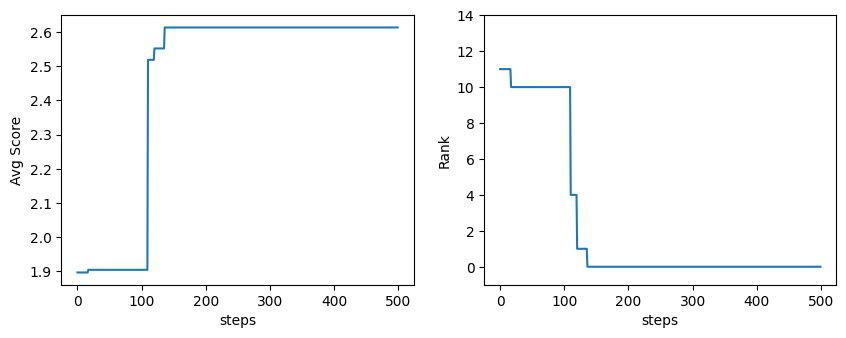

In [18]:
fig, axes = plt.subplot_mosaic("AB", sharex=True, figsize=(10, 3.5))

axes["A"].plot(learning_results['avg score']);
axes["A"].set_ylabel("Avg Score");

axes["B"].plot(learning_results['rank']);
axes["B"].set_ylim(-1, 14)
axes["B"].set_ylabel("Rank");

for letter in "AB":
    axes[letter].set_xlabel("steps");


In [20]:
import pickle

with open("current_table.pkl", "wb") as f:
    pickle.dump(current_table, f)

In [21]:
with open("current_table.pkl", "rb") as f:
    best_table = pickle.load(f)